In [11]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFE, RFECV


from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
)



In [19]:
def evaluate_performance(all_target, predicted, toplot=True,silent=True, save=None):
    all_target = np.array(all_target)
    predicted = np.array(predicted)
    fpr, tpr, thresholds = roc_curve(all_target, predicted)
    roc_auc = auc(fpr, tpr)
    ks = max(tpr-fpr)
    maxind = (tpr-fpr).argmax()

    event_rate = sum(all_target) / 1.0 / all_target.shape[0]
    cum_total = tpr * event_rate + fpr * (1-event_rate)
    minind, = np.nonzero(np.ravel(abs(cum_total - event_rate) == min(abs(cum_total - event_rate))))
    if minind.shape[0] > 0:
        minind = minind[0]

    if toplot:
        # KS plot
        plt.figure(figsize=(26,6))
        plt.subplot(1,4,1)
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], color='k', linestyle='--', linewidth=2)
        plt.title('KS='+str(round(ks,3))+ ' AUC='+str(round(roc_auc,3)), fontsize=20)
        plt.plot([fpr[maxind], fpr[maxind]], [fpr[maxind], tpr[maxind]], linewidth=4, color='r')
        plt.plot([fpr[minind]], [tpr[minind]], 'k.', markersize=10)

        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xlabel('False positive', fontsize=20); plt.ylabel('True positive', fontsize=20);
        if not silent:
            print ('KS=' + str(round(ks,3)) + ', AUC=' + str(round(roc_auc,3)) +', N='+str(predicted.shape[0]))
            print ('At threshold=' + str(round(event_rate, 3)) + ', TPR=' + str(round(tpr[minind],3)) + ', ' + str(int(round(tpr[minind]*event_rate*all_target.shape[0]))) + ' out of ' + str(int(round(event_rate*all_target.shape[0]))) ) 
            print ('At threshold=' + str(round(event_rate, 3)) + ', TPR=' + str(round(fpr[minind],3)) + ', ' + str(int(round(fpr[minind]*(1.0-event_rate)*all_target.shape[0]))) + ' out of ' + str(int(round((1.0-event_rate)*all_target.shape[0]))))  
    
        # Score distribution score
        plt.subplot(1,4,2)
        #print predicted.columns
        plt.hist(predicted, bins=20)
        plt.axvline(x=np.mean(predicted), linestyle='--')
        plt.axvline(x=np.mean(all_target), linestyle='--', color='g')
        plt.title('N='+str(all_target.shape[0])+' Tru='+str(round(np.mean(all_target),3))+' Pred='+str(round(np.mean(predicted),3)), fontsize=20)
        plt.xlabel('Target rate', fontsize=20)
        plt.ylabel('Count', fontsize=20)

        # Score average by percentile
        binnum = 10
        ave_predict = np.zeros((binnum))
        ave_target = np.zeros((binnum))
        indices = np.argsort(predicted)
        binsize = int(round(predicted.shape[0]/1.0/binnum))
        for i in range(binnum):
            startind = i*binsize
            endind = min(predicted.shape[0], (i+1)*binsize)
            ave_predict[i] = np.mean(predicted[indices[startind:endind]])
            ave_target[i] = np.mean(all_target[indices[startind:endind]])
        
        plt.subplot(1,4,3)
        plt.plot(ave_predict, 'b.-', label='Prediction', markersize=5)
        plt.plot(ave_target, 'r.-', label='Truth', markersize=5)
        # plt.legend(loc='lower right')
        plt.xlabel('Percentile', fontsize=20)
        plt.ylabel('Target rate', fontsize=20)
        plt.title("Sloping", fontsize=20)
        if not silent:
            print ('Ave_target: ' + str([round(i,4) for i in ave_target]))
            print ('Ave_predicted: ' + str(ave_predict))
            
            
        count_predict = np.zeros((binnum+1))
        count_target = np.zeros((binnum+1))
        indices = np.argsort(predicted,)
        binsize = int(round(predicted.shape[0]/1.0/binnum))
        for i in range(binnum+1):
            endind = min(predicted.shape[0], (i)*binsize)
            count_predict[i] = np.sum(all_target)-np.sum(all_target[indices[0:endind]])
            count_target[i] = np.sum(all_target)
        
        count_predict = list(count_predict)
        count_predict.reverse()
        ave_predict = list((count_predict/count_target))

        top_20_len = int(len(predicted)/5)
        top_20_ratio = np.sum(all_target[indices[-top_20_len:]])*100.0/np.sum(all_target)
        
        btm_10_len = int(len(predicted)/10)
        btm_10_ratio = np.sum(all_target[indices[:btm_10_len]])*100.0/np.sum(all_target)
        
        plt.subplot(1,4,4)
        plt.plot(ave_predict, 'b.-', markersize=5)
        # plt.legend(loc='up right')
        plt.xlabel('Top score bin(bad-->good)', fontsize=20)
        plt.ylabel('Capture rate', fontsize=20)
        plt.title("TOP20:{0}% , BTM10:{1}%".format(round(top_20_ratio,2),round(btm_10_ratio,2)), fontsize=20)
        if not silent:
            print ('#True: ' + str([int(i) for i in count_predict]))
            print ('%True: ' + str([round(i,2) for i in ave_predict]))            
            
        if save is not None:
            plt.savefig(save)
            
        plt.show()

    return ks


def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## LR classification

In [13]:
train_data = pd.read_csv("./../data/process/train_process.csv")
test_data = pd.read_csv("./../data/process/test_process.csv")

print(train_data.shape, test_data.shape)


## Preprocess the target
def handle_target(x, thresh=3.5):
    
    if x < thresh:
        return 0
    else:
        return 1
    
train_data["Stars"] = train_data["Stars"].replace("Unrated", -1).astype(float).apply(handle_target)
test_data["Stars"] = test_data["Stars"].replace("Unrated", -1).astype(float).apply(handle_target)

list_feature = [x for x in train_data if x != "Stars"]

X_train, y_train = train_data[list_feature], train_data["Stars"]
X_test, y_test = test_data[list_feature], test_data["Stars"]


(2064, 421) (516, 421)


/Users/tuanzai/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (420) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


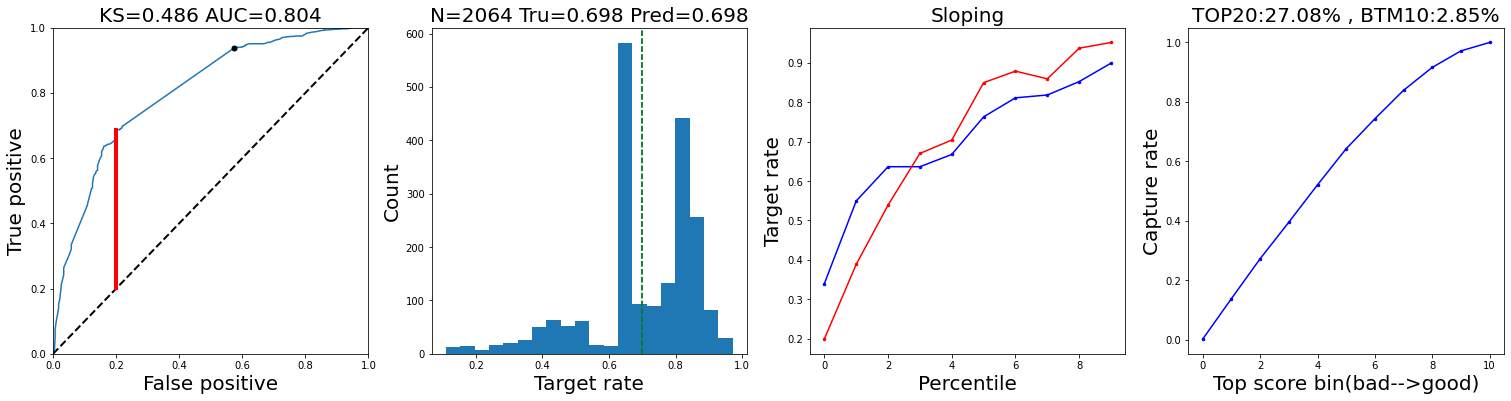

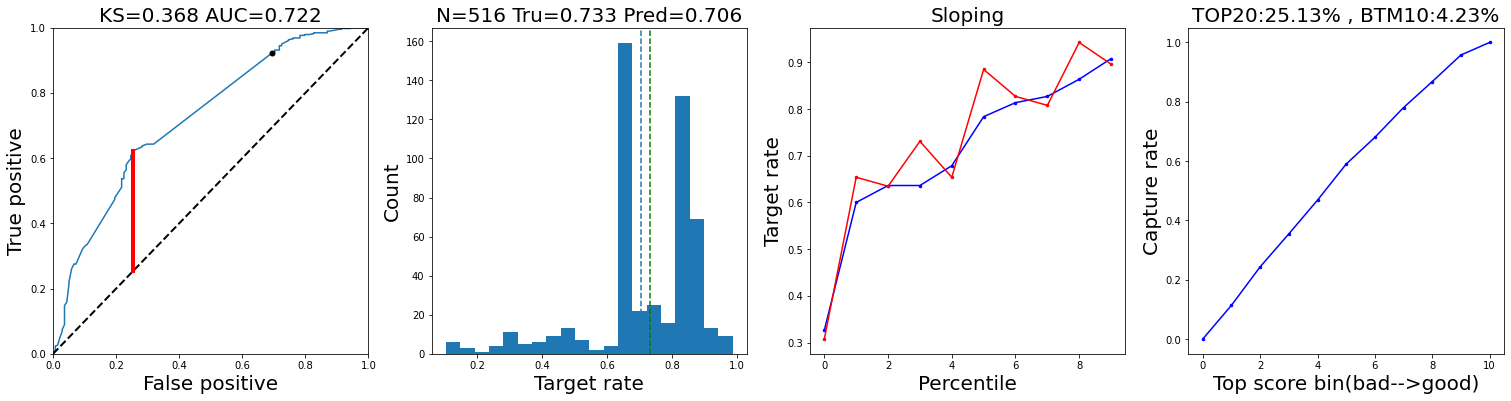

0.3680699332873246

In [21]:
pipe_rfe_ridgecv = make_pipeline(RFE(Ridge()), LogisticRegression())
pipe_rfe_ridgecv.fit(X_train, y_train)

y_prediction = pipe_rfe_ridgecv.predict_proba(X_test)

evaluate_performance(y_train, pipe_rfe_ridgecv.predict_proba(X_train)[:, 1], save="./../results/train_metrics.jpg")

evaluate_performance(y_test, pipe_rfe_ridgecv.predict_proba(X_test)[:, 1], save="./../results/test_metrics.jpg")

### Other Metrics

In [17]:
metrics = [
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    ]


prediction = pipe_rfe_ridgecv.predict(X_test)
prediction_proba = pipe_rfe_ridgecv.predict_proba(X_test)[:,1]


for i in metrics:

  print(i.__name__, i(y_test, prediction))

accuracy_score 0.7674418604651163
confusion_matrix [[ 38 100]
 [ 20 358]]
f1_score 0.8564593301435407
precision_score 0.7816593886462883
recall_score 0.9470899470899471


### Coefficients

In [18]:
new_columns = pipe_rfe_ridgecv[0].get_feature_names_out()

coef_df = pd.DataFrame({"coef": pipe_rfe_ridgecv[-1].coef_[0], "vars": new_columns})
coef_df["coef_abs"] = abs(coef_df["coef"])

In [7]:
coef_df.sort_values("coef_abs", ascending=False).head(20)

,coef,vars,coef_abs
132,1.728120,Brand_Samyang Foods,1.728120
64,-1.710197,Brand_Knorr,1.710197
191,-1.557720,Country_Canada,1.557720
121,-1.488140,Brand_Ripe'n'Dry,1.488140
206,1.483626,goreng,1.483626
204,1.462231,Country_Singapore,1.462231
68,-1.451897,Brand_Koyo,1.451897
25,1.395956,Brand_Dragonfly,1.395956
201,-1.359974,Country_Netherlands,1.359974
23,-1.342896,Brand_Doll,1.342896


In [25]:
print("Like variables")

coef_df.sort_values("coef", ascending=False).head(20).to_csv("./../results/Top_20_Good_features.csv", index=False)

coef_df.sort_values("coef", ascending=False).head(20)


Like variables


,coef,vars,coef_abs
132,1.728120,Brand_Samyang Foods,1.728120
206,1.483626,goreng,1.483626
204,1.462231,Country_Singapore,1.462231
25,1.395956,Brand_Dragonfly,1.395956
165,1.283582,Brand_Tseng Noodles,1.283582
84,1.275756,Brand_Master Kong,1.275756
198,1.265622,Country_Malaysia,1.265622
182,1.258166,Brand_Yamachan,1.258166
57,1.241617,Brand_Kabuto Noodles,1.241617
109,1.133410,Brand_Paldo,1.133410


In [24]:
print("Hate variables")

coef_df.sort_values("coef", ascending=True).head(20).to_csv("./../results/Top_20_Bad_features.csv", index=False)

coef_df.sort_values("coef", ascending=True).head(20)


Hate variables


,coef,vars,coef_abs
64,-1.710197,Brand_Knorr,1.710197
191,-1.557720,Country_Canada,1.557720
121,-1.488140,Brand_Ripe'n'Dry,1.488140
68,-1.451897,Brand_Koyo,1.451897
201,-1.359974,Country_Netherlands,1.359974
23,-1.342896,Brand_Doll,1.342896
137,-1.242377,Brand_Shirakiku,1.242377
32,-1.185306,Brand_Four Seas,1.185306
12,-1.151730,Brand_Chewy,1.151730
7,-1.145100,Brand_Baijia,1.145100
